## Fase 2 - Propuestas de KPI: explicación y calculo.

In [ ]:
# * ======================
# * LIBRERÍAS NECESARIAS
# * ======================

# * Manipulación y análisis
import pandas as pd
import numpy as np

# * Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# * Estadística
from scipy.stats import pearsonr

# * Geo-análisis y mapas
import geopandas as gpd
import contextily as ctx
import mapclassify
import matplotlib.colors as mcolors

# * Mapa interactivo (Quizás no se necesite)
import folium
import json
import branca.colormap as cm

# * Ajustes visuales generales
sns.set(style='whitegrid')
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# * Ajustes de advertencias
import warnings
warnings.filterwarnings("ignore")

In [119]:
crime = pd.read_csv('../data/processed/super_clena_crimes.csv')
inmu = pd.read_csv('../data/processed/Neighborhood_zhvi_clean_with_yoy.csv')
business = pd.read_csv('../data/processed/Business_clean.csv')

print(f'Columnas de crimen: \n {crime.columns},\n shape: {crime.shape}')
print('\n')
print(f'Columnas de inmuebles: \n{inmu.columns},\n shape: {inmu.shape}')
print('\n')
print(f'Columnas de business: \n{business.columns},\n shape: {business.shape}')

Columnas de crimen: 
 Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Crm Cd', 'Crm Cd Desc', 'Vict Age', 'Vict Sex',
       'Vict Descent', 'Premis Desc', 'LOCATION', 'LAT', 'LON', 'Tipo_Delito',
       'Año', 'geometry', 'Neighborhood'],
      dtype='object'),
 shape: (1007324, 20)


Columnas de inmuebles: 
Index(['RegionID', 'SizeRank', 'RegionName', 'date', 'Price', 'year', 'month',
       'YoY_change'],
      dtype='object'),
 shape: (29997, 8)


Columnas de business: 
Index(['Unnamed: 0', 'LOCATION ACCOUNT #', 'BUSINESS NAME', 'STREET ADDRESS',
       'CITY', 'ZIP CODE', 'NAICS', 'PRIMARY NAICS DESCRIPTION',
       'COUNCIL DISTRICT', 'LOCATION START DATE', 'LOCATION END DATE',
       'LOCATION', 'Latitude', 'Longitude', 'geometry', 'index_right',
       'neighborhoods', 'Year star', 'Year end', 'Month star', 'Month end'],
      dtype='object'),
 shape: (1046644, 21)


In [120]:

# * ===============================
# * Limpieza inicial y estandarización
# * ===============================

# * 1. Unificar nombre de vecindarios (columna: neighborhood_clean)
# * --- Crimen ---
crime['neighborhood_clean'] = crime['Neighborhood'].str.lower().str.strip()
# * --- Inmuebles ---
inmu['neighborhood_clean'] = inmu['RegionName'].str.lower().str.strip()
# * --- Negocios ---
business['neighborhood_clean'] = business['neighborhoods'].str.lower().str.strip()

# * 2. Convertir columnas de fecha a tipo datetime
# * Crimen
crime['DATE OCC'] = pd.to_datetime(crime['DATE OCC'], errors='coerce')
# * Inmuebles
inmu['date'] = pd.to_datetime(inmu['date'])
# * Negocios
business['LOCATION START DATE'] = pd.to_datetime(business['LOCATION START DATE'], errors='coerce')
business['LOCATION END DATE'] = pd.to_datetime(business['LOCATION END DATE'], errors='coerce')

# * 3. Confirmación rápida (opcional) para ver que todo esté correcto
print("\nTipos de datos después de transformación:\n")
print(f"crime['DATE OCC']: {crime['DATE OCC'].dtype}")
print(f"inmu['date']: {inmu['date'].dtype}")
print(f"business['LOCATION START DATE']: {business['LOCATION START DATE'].dtype}")
print(f"Columnas unificadas: {'neighborhood_clean' in crime.columns and 'neighborhood_clean' in inmu.columns and 'neighborhood_clean' in business.columns}")



Tipos de datos después de transformación:

crime['DATE OCC']: datetime64[ns]
inmu['date']: datetime64[ns]
business['LOCATION START DATE']: datetime64[ns]
Columnas unificadas: True


## KPI 1: Índice de Influencia Comercial sobre la Vivienda (IICV)

**Objetivo:**  
El IICV busca medir cómo la actividad comercial (densidad de negocios) en un vecindario influye en el precio mediano de la vivienda. Esto nos ayuda a entender si existe una relación que indique, por ejemplo, que los vecindarios con mayor actividad comercial tienden a tener precios de vivienda más altos o viceversa.

---

### Fórmulas

La densidad comercial por vecindario podemos aproximarla como:

$$ C_b = \frac{N_b}{A_b} $$

Donde:

- \( $C_b$ \): Densidad comercial del vecindario.  
- \( $N_b$ \): Número total de negocios en el vecindario.  
- \( $A_b$ \): Área del vecindario (en km² o mi²).

Luego, el IICV se define como la correlación entre:

- \( $\hat{B}_n = (C_{b_1}, C_{b_2}, \dots, C_{b_k})$ \): Densidades comerciales por vecindario.  
- \( $\hat{V}_n = (P_{v_1}, P_{v_2}, \dots, P_{v_k})$ \): Precios medianos de vivienda por vecindario.

La fórmula final del KPI es:

$$ \text{IICV} = \text{Corr}(\hat{B}_n, \hat{V}_n) $$

---

### ¿Por qué se hace así?

- **Densidad comercial** (\( $\hat{B}_n$ \)): Refleja el nivel de actividad económica de una zona. Una mayor concentración de negocios puede significar más infraestructura, servicios y empleos.
- **Precio mediano de vivienda** (\( $\hat{V}_n$ \)): Es un valor más robusto que el promedio y evita que valores atípicos distorsionen el análisis.
- **Correlación**: Nos permite cuantificar si existe una relación (y de qué tipo) entre ambas variables. Este valor será nuestro KPI.

---

### Lógica en el DataFrame

1. Calcular la densidad comercial por vecindario (una vez que se tenga el dataset de negocios y el área de cada vecindario).
2. Obtener el precio mediano de vivienda por vecindario (esto ya está en `inmuebles`).
3. Unir ambos conjuntos de datos por `RegionName` o `Vecindario` la unificares y llamaremos `neighborhood_clean`.
4. Calcular la correlación usando `pearsonr` o `np.corrcoef`.


In [121]:
# --- KPI 1: Densidad comercial y precios recientes por vecindario ---

# Cargamos el área del vecindario desde el GeoJSON
geojson_url = "https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/eva_pereira_lahub_BA_24d4f6a092ee4506/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
neigh_gdf = gpd.read_file(geojson_url)

neigh_area_df = neigh_gdf[['name', 'Shape__Area']].copy()
neigh_area_df.rename(columns={'name': 'Neighborhood', 'Shape__Area': 'Area_m2'}, inplace=True)
neigh_area_df['neighborhood_clean'] = neigh_area_df['Neighborhood'].str.lower().str.strip()
neigh_area_df['Area_sqmi'] = neigh_area_df['Area_m2'] / 2.59e6  # m² a millas²

# 2. Calculamos la densidad (cantidad) comercial
negocios_por_vecindario = business.groupby('neighborhood_clean').size().reset_index(name='num_negocios')
densidad_df = negocios_por_vecindario.merge(
    neigh_area_df[['neighborhood_clean', 'Area_sqmi']],
    on='neighborhood_clean',
    how='left'
)
densidad_df['densidad_comercial'] = densidad_df['num_negocios'] / densidad_df['Area_sqmi']

# 3. Obtenemos el  precio mediano más reciente por vecindario
ultimos_precios = (
    inmu.sort_values('date')
    .groupby('neighborhood_clean')
    .tail(1)[['neighborhood_clean', 'Price']]
)

# 4. Unir datasets, densidad y ultimos precios
df_kpi = densidad_df.merge(ultimos_precios, on='neighborhood_clean', how='inner')

# Eliminamos vecindarios sin área conocida (necesaria para calcular densidad) porque se agregaron unos al normalizar
df_kpi = df_kpi.dropna(subset=['Area_sqmi', 'densidad_comercial', 'Price'])

# Verificación rápida
#print(f"df_kpi shape (final): {df_kpi.shape}")
#print(df_kpi.isna().sum())

# 5. Calculamos la correlación (IICV) nuestro kpi
iicv_valor, p_valor = pearsonr(df_kpi['densidad_comercial'], df_kpi['Price'])
print(f"IICV (correlación): {iicv_valor:.3f} — p-valor: {p_valor:.3f}")



IICV (correlación): -0.227 — p-valor: 0.053


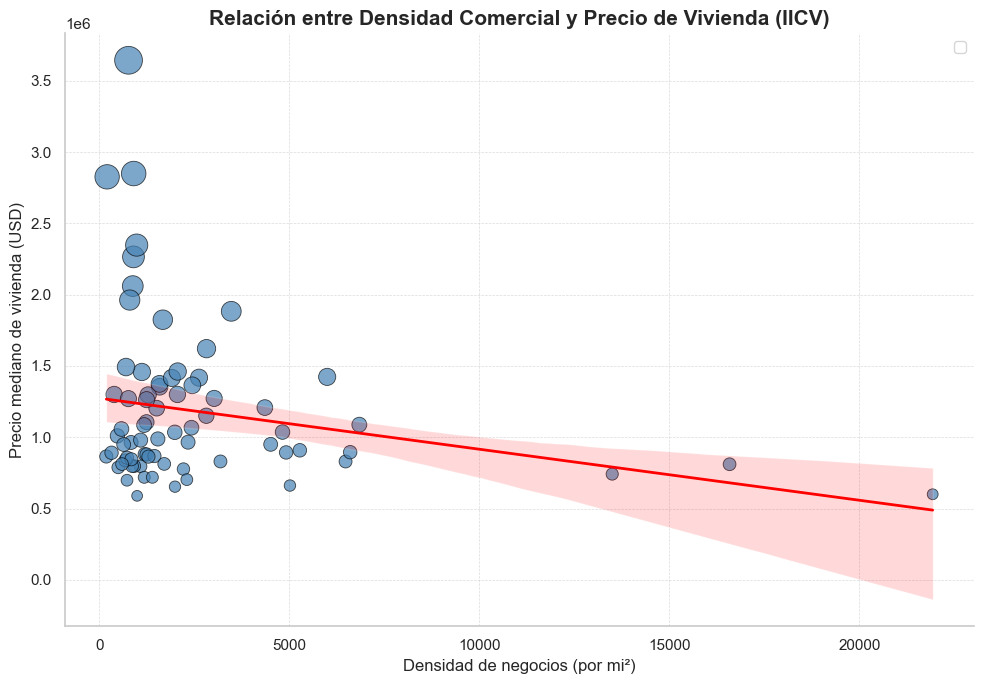

IICV (correlación): -0.227 — p-valor: 0.053


In [122]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_kpi, # DataFrame con densidad comercial y precios
    x='densidad_comercial',
    y='Price',
    color='steelblue', # Color de los puntos
    edgecolor='black', # Color del borde de los puntos
    linewidth=0.6, # Grosor del borde de los puntos
    alpha=0.7, # Transparencia de los puntos
    size=df_kpi['Price'] / 1000, # Tamaño de los puntos proporcional al precio
    sizes=(60, 400), # Tamaño de los puntos
    legend=False # Desactivar leyenda de tamaño
)
sns.regplot( # Para una regresión lineal
    data=df_kpi,
    x='densidad_comercial',
    y='Price',
    scatter=False, # No mostrar puntos de dispersión
    color='red', # Color de la línea de regresión
    line_kws={'linewidth': 2, 'label': 'Tendencia'}, # Personalización de la línea de regresión
    ci=95 # Intervalo de confianza del 95%
)
plt.title('Relación entre Densidad Comercial y Precio de Vivienda (IICV)', fontsize=15, weight='bold')
plt.xlabel('Densidad de negocios (por mi²)', fontsize=12)
plt.ylabel('Precio mediano de vivienda (USD)', fontsize=12)
plt.legend(loc='upper right', frameon=True)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
sns.despine()
plt.tight_layout()
plt.show()

print(f"IICV (correlación): {iicv_valor:.3f} — p-valor: {p_valor:.3f}")


La correlación obtenida entre la densidad comercial y el precio mediano de la vivienda en Los Ángeles fue:

> **`-0.227`** con un **p-valor de `0.053`**

Esto indica una **relación negativa débil** entre ambas variables.  
En otras palabras, **a mayor densidad de negocios, menor es el precio de la vivienda**, aunque esta relación **no es particularmente fuerte ni significativa a nivel estadístico**.



Entonces:
- En algunos vecindarios con **alta actividad comercial**, los precios de vivienda **no son necesariamente más altos**.
- Esto **contradice la idea común** de que un mayor actividad comercial siempre incrementa el valor residencial.
- Al menos en este caso, el comercio **no parece elevar de forma directa** el valor inmobiliario.  
  Puede haber otros factores más determinantes, como la seguridad.

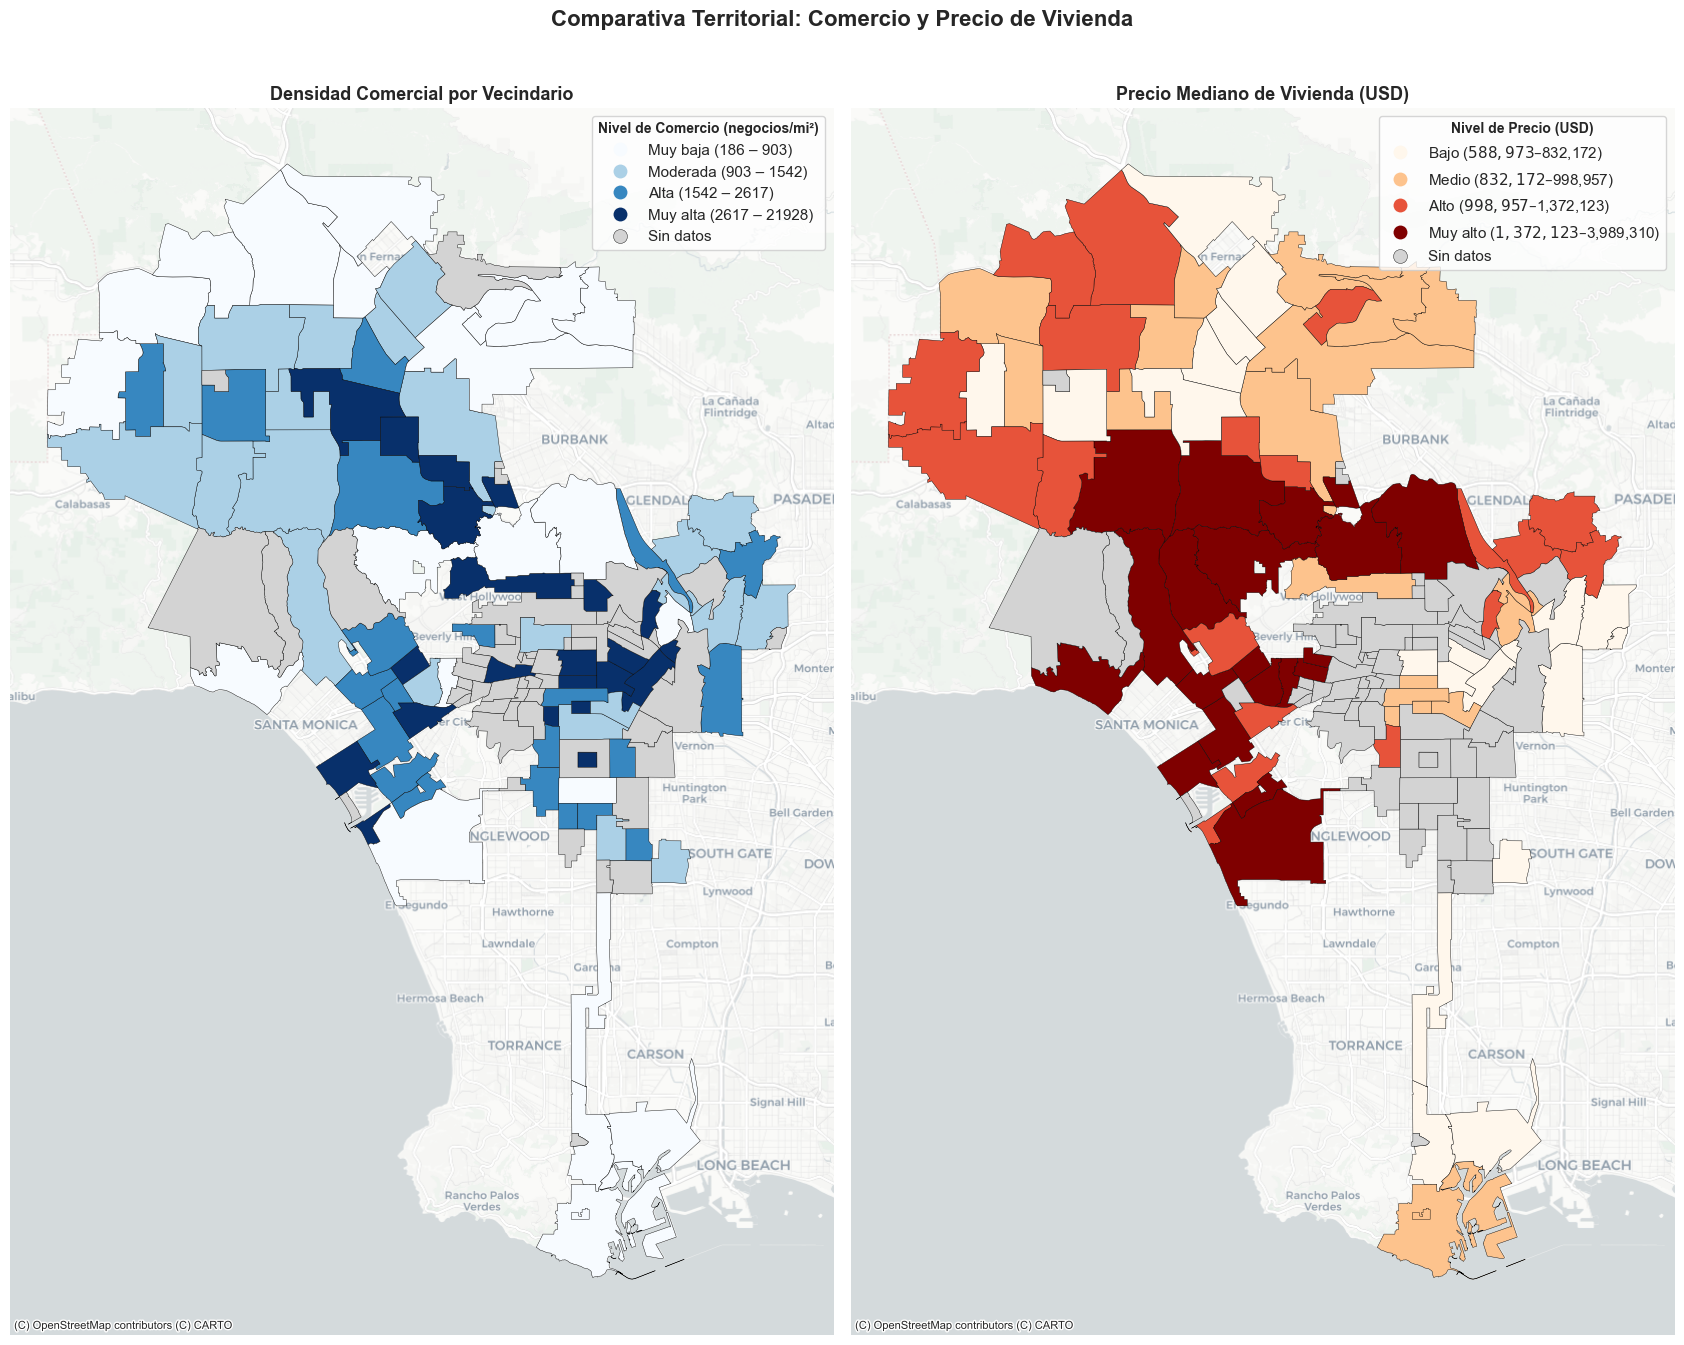

<Figure size 640x480 with 0 Axes>

In [123]:
# Crear GeoDataFrame base
map_gdf = neigh_gdf[['name', 'geometry']].copy()
map_gdf['neighborhood_clean'] = map_gdf['name'].str.lower().str.strip()

# Unir con densidad y precios
map_gdf = map_gdf.merge(
    densidad_df[['neighborhood_clean', 'densidad_comercial']],
    on='neighborhood_clean',
    how='left'
)
map_gdf = map_gdf.merge(
    ultimos_precios[['neighborhood_clean', 'Price']],
    on='neighborhood_clean',
    how='left'
)

# Re-proyección para fondo de mapa
map_gdf = map_gdf.to_crs(epsg=3857)

# crea figura
fig, ax = plt.subplots(1, 2, figsize=(17, 14))

# ------------------ Mapa 1: Densidad Comercial ------------------
map_gdf.plot(
    column='densidad_comercial',
    cmap='Blues',
    scheme='Quantiles', # para poder separar
    k=4, # en cuantos grupos
    legend=True,
    edgecolor='black',
    linewidth=0.3,
    ax=ax[0],
    missing_kwds={'color': 'lightgrey', 'edgecolor': 'black', 'label': 'Sin datos'}
)
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Positron)
ax[0].set_title("Densidad Comercial por Vecindario", fontsize=13, weight='bold')
ax[0].axis('off')

# Leyenda densidad
leg_dens = ax[0].get_legend()
if leg_dens:
    leg_dens.set_title("Nivel de Comercio (negocios/mi²)", prop={'size': 10, 'weight': 'bold'})
    etiquetas = ["Muy baja", "Moderada", "Alta", "Muy alta"]
    for i, text in enumerate(leg_dens.get_texts()):
        if "," in text.get_text():
            l, r = text.get_text().replace("(", "").replace("]", "").split(",")
            text.set_text(f"{etiquetas[i]} ({float(l):.0f} – {float(r):.0f})")
        elif "Sin datos" in text.get_text():
            text.set_text("Sin datos")

# ------------------ Mapa 2: Precio de Vivienda ------------------
map_gdf.plot(
    column='Price',
    cmap='OrRd',
    scheme='Quantiles',
    k=4,
    legend=True,
    edgecolor='black',
    linewidth=0.3,
    ax=ax[1],
    missing_kwds={'color': 'lightgrey', 'edgecolor': 'black', 'label': 'Sin datos'}
)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Positron)
ax[1].set_title("Precio Mediano de Vivienda (USD)", fontsize=13, weight='bold')
ax[1].axis('off')

# Leyenda precios
leg_precio = ax[1].get_legend()
if leg_precio:
    leg_precio.set_title("Nivel de Precio (USD)", prop={'size': 10, 'weight': 'bold'})
    etiquetas = ["Bajo", "Medio", "Alto", "Muy alto"]
    for i, text in enumerate(leg_precio.get_texts()):
        if "," in text.get_text():
            l, r = text.get_text().replace("(", "").replace("]", "").split(",")
            text.set_text(f"{etiquetas[i]} (${int(float(l)):,} – ${int(float(r)):,})")
        elif "Sin datos" in text.get_text():
            text.set_text("Sin datos")

# ------------------ Título General ------------------
plt.suptitle("Comparativa Territorial: Comercio y Precio de Vivienda", fontsize=16, weight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

plt.savefig("../data/maps/IICV_mapa_final_kpi1.png", dpi=300, bbox_inches='tight')

- El primer mapa muestra la **concentración de negocios** por vecindario, categorizada desde *muy baja* hasta *muy alta*.

- El segundo mapa presenta la **variación de precios de vivienda** por zona.

- Al comparar ambos, es evidente que **las zonas con mayor densidad comercial no coinciden necesariamente con aquellas de mayor valor inmobiliario**.

### Desfase entre Comercio y Precio de Vivienda

Además del valor de correlación entre comercio y vivienda, analizamos el **desfase de rankings** entre ambos indicadores.

#### ¿Cómo se calcula?
1. Se asigna un **ranking descendente** (mayor = mejor) a cada vecindario según:
   - Densidad comercial
   - Precio mediano de vivienda
2. Se calcula la diferencia entre estos rankings:
   - Si el ranking comercial es mucho más alto que el de precios → "Comercio mayor que precio"
   - Si están similares → "Balanceado"
   - Si el precio es mucho mayor que el comercio → "Precio mayor que comercio"

#### ¿Qué aporta este análisis?
- Identifica **zonas desequilibradas**, donde:
  - Hay mucha actividad comercial pero precios bajos (posible subvalorización o rezago residencial)
  - Hay precios altos pero poca actividad comercial (zonas residenciales de lujo, poco dinámicas)

El **mapa categorizado** permite visualizar rápidamente **qué tipo de desfase ocurre en cada vecindario**, ayudando a **guiar políticas urbanas, estrategias de inversión o priorización territorial**.


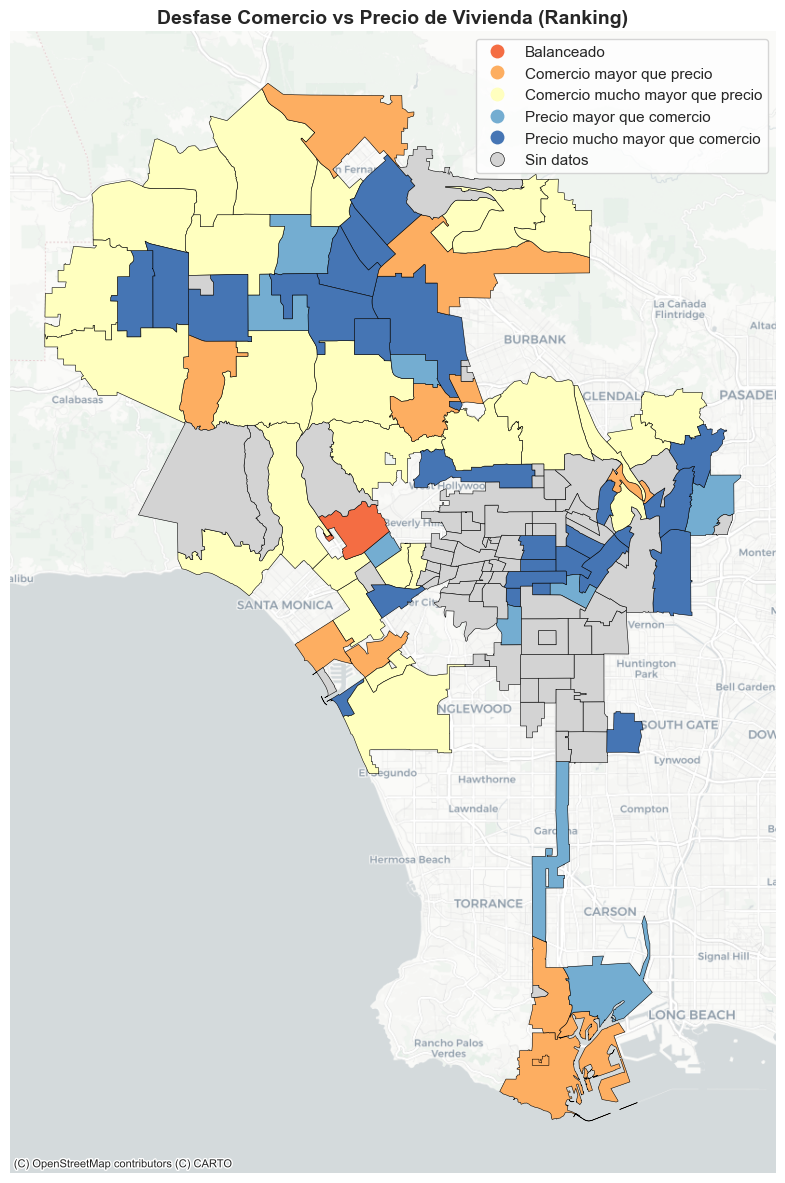

<Figure size 640x480 with 0 Axes>

In [124]:
map_gdf_clean = map_gdf.copy()
map_gdf_valid = map_gdf_clean.dropna(subset=['densidad_comercial', 'Price']).copy()

# Calcular rankings (mayor valor = mejor ranking)
map_gdf_valid['rank_densidad'] = map_gdf_valid['densidad_comercial'].rank(ascending=False)
map_gdf_valid['rank_precio'] = map_gdf_valid['Price'].rank(ascending=False)

# Calcular diferencia de ranking
map_gdf_valid['diff_rank'] = map_gdf_valid['rank_densidad'] - map_gdf_valid['rank_precio']

# Clasificación cualitativa
def clasificar_diferencia(x):
    if pd.isna(x):
        return "Sin datos"
    elif x >= 10:
        return "Comercio mucho mayor que precio"
    elif x >= 3:
        return "Comercio mayor que precio"
    elif x > -3:
        return "Balanceado"
    elif x > -10:
        return "Precio mayor que comercio"
    else:
        return "Precio mucho mayor que comercio"

map_gdf_valid['diff_cat'] = map_gdf_valid['diff_rank'].apply(clasificar_diferencia)

# Volver a unir al GeoDataFrame original para conservar sin datos
map_gdf_clean = map_gdf_clean.merge(
    map_gdf_valid[['neighborhood_clean', 'diff_cat']],
    on='neighborhood_clean',
    how='left'
)

# Reproyectar
map_gdf_clean = map_gdf_clean.to_crs(epsg=3857)

# Definir paleta de colores
colores = {
    "Comercio mucho mayor que precio": "#f46d43",
    "Comercio mayor que precio": "#fdae61",
    "Balanceado": "#ffffbf",
    "Precio mayor que comercio": "#74add1",
    "Precio mucho mayor que comercio": "#4575b4",
    "Sin datos": "lightgrey"
}

# Mapa
fig, ax = plt.subplots(figsize=(10, 12))
map_gdf_clean.plot(
    column='diff_cat',
    ax=ax,
    legend=True,
    edgecolor='black',
    linewidth=0.4,
    cmap=plt.matplotlib.colors.ListedColormap([colores[c] for c in colores if c != "Sin datos"]),
    categorical=True,
    missing_kwds={
        'color': colores["Sin datos"],
        'edgecolor': 'black',
        'label': 'Sin datos'
    }
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Desfase Comercio vs Precio de Vivienda (Ranking)", fontsize=14, weight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

plt.savefig("../data/maps/RANKIN_mapa_kpi1_1.png", dpi=300, bbox_inches='tight')

Este mapa compara el nivel de comercio y el precio de vivienda en cada vecindario, mostrando si están equilibrados o si hay un desfase entre ambos.

`AMARILLO` - Mucho comercio, bajo precio: Zonas con alta actividad comercial, pero donde las casas no son caras. Puede ser una oportunidad de desarrollo o un síntoma de rezago habitacional.

`NARANJA` - Más comercio que precio: El comercio está por encima del valor de las viviendas, aunque no tanto. Posible potencial de crecimiento inmobiliario.

`ROJO` - Balanceado: Comercio y precios van de la mano. Nada inusual.

`AZUL-CLARO` - Más precio que comercio: Las casas valen más de lo que indicaría el nivel de comercios. Puede ser por prestigio, ubicación o atributos no comerciales.

`AZUL-MARINO`- Precio mucho mayor que comercio: Zonas con precios altos y poco comercio. Probablemente residenciales exclusivas.

`GRIS` - Sin datos: Áreas con información insuficiente.

## KPI 2: Índice de Sensibilidad del Valor Inmobiliario a la Seguridad (ISV)

### Objetivo

Este indicador busca evaluar **cómo influye el cambio en la criminalidad sobre el cambio en el precio de la vivienda**. Nos permite analizar si los incrementos o reducciones en la inseguridad se reflejan directamente en el comportamiento del mercado inmobiliario a nivel vecindario.

---

### Fórmulas

**Cambio porcentual de criminalidad por periodo** (mes o año):

$$ d_c = \frac{C_t}{C_{t-1}} - 1 $$

Donde:

- \( $C_t$ \): Número total de crímenes en el periodo \( $t$ \)
- \( $C_{t-1}$ \): Número total de crímenes en el periodo anterior

---

**Cambio porcentual del precio mediano de la vivienda**:

$$ d_p = \frac{P_t}{P_{t-1}} - 1 $$

Donde:

- \( $P_t$ \): Precio mediano de la vivienda en el periodo \( $t$ \)
- \( $P_{t-1}$ \): Precio mediano del periodo anterior

---

### Índice de Sensibilidad del Valor Inmobiliario a la Seguridad:

Se define como la **correlación entre el cambio porcentual de criminalidad y el cambio porcentual del precio inmobiliario**, por vecindario:

$$ \text{ISV} = \text{Corr}(d_c, d_p) $$

---

### Lógica de implementación

1. Agrupar el dataset de **crimen** por `Vecindario_Oficial` y `Mes/Año` para obtener \( $C_t$ \).
2. Calcular el **cambio porcentual mensual** en crímenes \( d_c \) por vecindario.
3. Agrupar el dataset de **vivienda** (`inmu`) por `RegionName` y `date` para obtener \( $P_t$ \).
4. Calcular el **cambio porcentual mensual** del precio \( d_p \) por vecindario.
5. Unir ambos datasets por `vecindario` y `fecha`.
6. Calcular la **correlación** entre las columnas `d_c` y `d_p` para cada vecindario.
7. Analizar si existe una relación significativa (positiva o negativa) entre los cambios.

---

### Como lo interpretaremos Interpretación

- Un valor **positivo** del ISV sugiere que **más crimen = precios más altos** (inusual, pero posible en zonas gentrificadas).
- Un valor **negativo** del ISV sugiere que **más crimen = precios más bajos**, lo cual es común en muchas áreas.
- Un valor cercano a **cero** indica **falta de relación directa** entre las variables en ese vecindario.



In [125]:
# --- Crimen mensual por vecindario ---
# Extraer mes como string para merge
crime['mes'] = crime['DATE OCC'].dt.to_period('M').astype(str)

# Agrupar por vecindario y mes: total de crímenes
crimen_mensual = (
    crime.groupby(['neighborhood_clean', 'mes'])
    .size()
    .reset_index(name='total_crimenes')
)

# Calcular variación porcentual mensual del crimen
crimen_mensual['variacion_crimen'] = (
    crimen_mensual
    .groupby('neighborhood_clean')['total_crimenes']
    .pct_change()
)

# --- Precio mensual por vecindario ---
inmu['mes'] = inmu['date'].dt.to_period('M').astype(str)

precio_mensual = (
    inmu.groupby(['neighborhood_clean', 'mes'])['Price']
    .median()
    .reset_index(name='precio_median_mensual')
)

# Calcular variación porcentual mensual del precio
precio_mensual['variacion_precio'] = (
    precio_mensual
    .groupby('neighborhood_clean')['precio_median_mensual']
    .pct_change()
)

# --- Unir datasets ---
isv_df = crimen_mensual.merge(
    precio_mensual,
    on=['neighborhood_clean', 'mes'],
    how='inner'
).dropna(subset=['variacion_crimen', 'variacion_precio'])

# --- ISV global ---
from scipy.stats import pearsonr

isv_valor, p_valor = pearsonr(isv_df['variacion_crimen'], isv_df['variacion_precio'])
print(f"ISV global: {isv_valor:.3f} — p-valor: {p_valor:.3f}")

# --- ISV por vecindario ---
isv_por_vecindario = (
    isv_df.groupby('neighborhood_clean')[['variacion_crimen', 'variacion_precio']]
    .corr()
    .iloc[0::2, -1]
    .reset_index()
    .rename(columns={'level_1': 'tipo', 'variacion_precio': 'ISV'})
    .query("tipo == 'variacion_crimen'")
)

print(isv_por_vecindario.head(10))


ISV global: 0.073 — p-valor: 0.000
  neighborhood_clean              tipo       ISV
0    adams-normandie  variacion_crimen  0.075070
1             arleta  variacion_crimen  0.114216
2  arlington heights  variacion_crimen  0.155105
3    atwater village  variacion_crimen  0.122764
4      beverly crest  variacion_crimen  0.169731
5        beverlywood  variacion_crimen -0.076720
6      boyle heights  variacion_crimen  0.053773
7          brentwood  variacion_crimen  0.152381
8        canoga park  variacion_crimen  0.104300
9       century city  variacion_crimen  0.023858


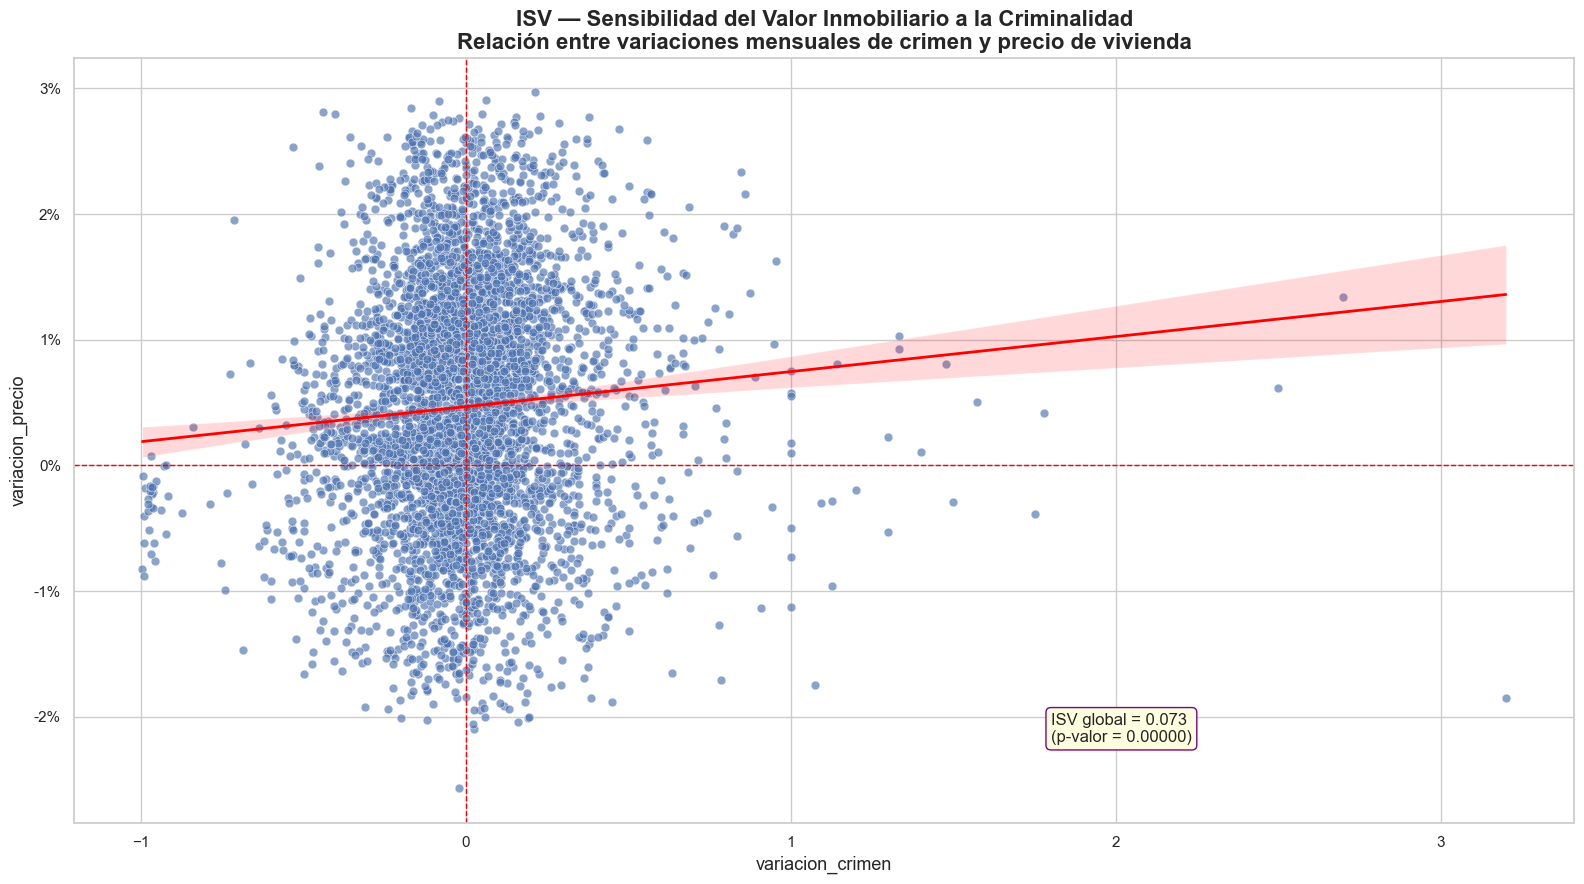

In [126]:
# Gráfico principal
plt.figure(figsize=(16, 9))
sns.set(style="whitegrid")

# Scatterplot
sns.scatterplot(
    data=isv_df,
    x='variacion_crimen',
    y='variacion_precio',
    alpha=0.65,
    s=40,
    edgecolor='w',
    linewidth=0.5
)

# Títulos y ejes
plt.title('ISV — Sensibilidad del Valor Inmobiliario a la Criminalidad\nRelación entre variaciones mensuales de crimen y precio de vivienda', fontsize=16, weight='bold')
plt.xlabel('Variación mensual de criminalidad (%)', fontsize=13)
plt.ylabel('Variación mensual del precio de vivienda (%)', fontsize=13)

# Líneas guía
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1)

sns.regplot(
    data=isv_df,
    x='variacion_crimen',
    y='variacion_precio',
    scatter=False, # No mostrar puntos de dispersión
    color='red',
    line_kws={'linewidth': 2} # Personalización de la línea de regresión
)

# Anotación del valor del ISV Global
plt.text(
    x=1.8, y=-0.022, 
    s=f"ISV global = {isv_valor:.3f}\n(p-valor = {p_valor:.5f})",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", edgecolor="purple")
)

from matplotlib.ticker import FuncFormatter
#plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))


plt.tight_layout()
plt.show()

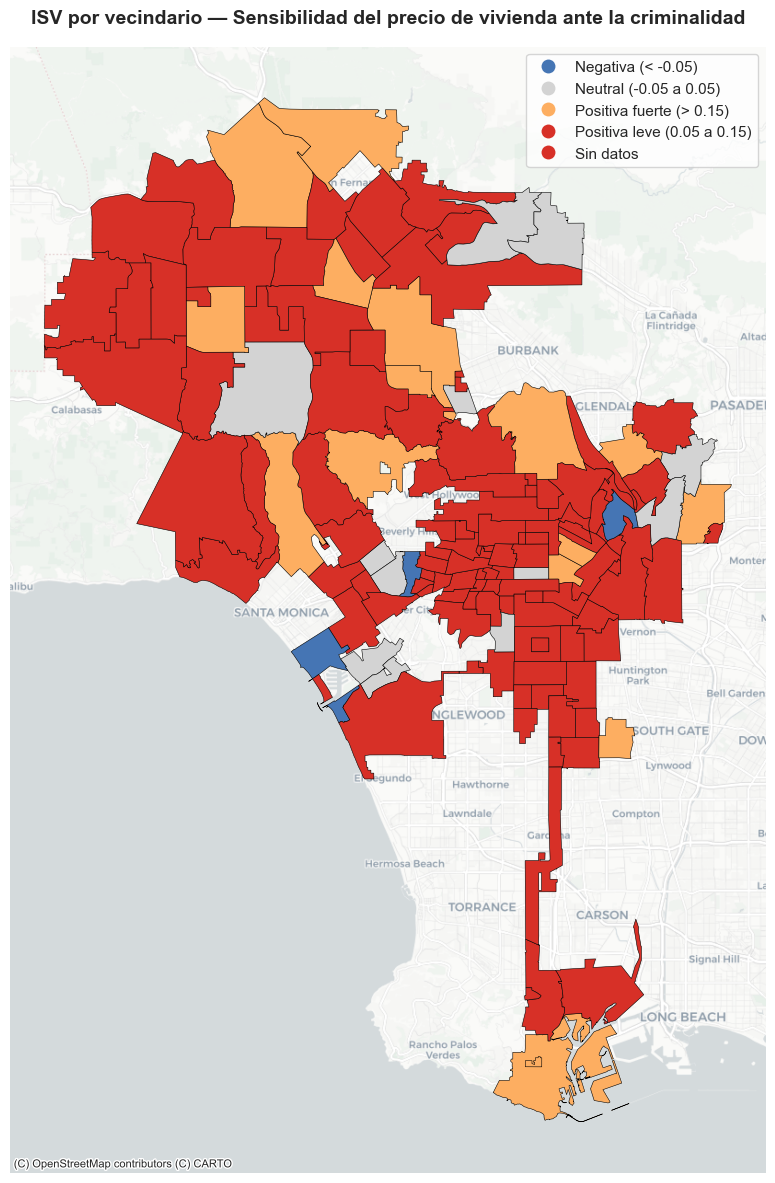

<Figure size 640x480 with 0 Axes>

In [127]:
# --- MAPA ISV POR VECINDARIO ---

# Preparar base del mapa con geometría y vecindarios normalizados
map_isv = neigh_gdf[['name', 'geometry']].copy()
map_isv.rename(columns={'name': 'Neighborhood'}, inplace=True)
map_isv['neighborhood_clean'] = map_isv['Neighborhood'].str.lower().str.strip()

# Unir con resultados de ISV por vecindario
map_isv = map_isv.merge(
    isv_por_vecindario[['neighborhood_clean', 'ISV']],
    on='neighborhood_clean',
    how='left'
)

# Clasificar ISV en categorías interpretables
def clasificar_isv(valor):
    if pd.isna(valor):
        return "Sin datos"
    elif valor < -0.05:
        return "Negativa (< -0.05)"
    elif valor < 0.05:
        return "Neutral (-0.05 a 0.05)"
    elif valor < 0.15:
        return "Positiva leve (0.05 a 0.15)"
    else:
        return "Positiva fuerte (> 0.15)"

map_isv['categoria_isv'] = map_isv['ISV'].apply(clasificar_isv)

# Reproyectar para mapa base
map_isv = map_isv.to_crs(epsg=3857)

# Definimos los colores que se pueden personalizar
colores_isv = {
    "Negativa (< -0.05)": "#4575b4",         # Azul fuerte
    "Neutral (-0.05 a 0.05)": "#d3d3d3",      # Gris claro
    "Positiva leve (0.05 a 0.15)": "#fdae61", # Naranja suave
    "Positiva fuerte (> 0.15)": "#d73027",    # Rojo fuerte
    "Sin datos": "lightgrey"
}

# Crear mapa
fig, ax = plt.subplots(figsize=(10, 12))
map_isv.plot(
    column='categoria_isv',
    cmap=plt.matplotlib.colors.ListedColormap([colores_isv[c] for c in colores_isv if c != "Sin datos"]),
    legend=True,
    categorical=True,
    edgecolor='black',
    linewidth=0.4,
    ax=ax,
    missing_kwds={
        'color': colores_isv["Sin datos"],
        'edgecolor': 'black',
        'label': 'Sin datos'
    }
)

# Añadir fondo de mapa y estética
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("ISV por vecindario — Sensibilidad del precio de vivienda ante la criminalidad", fontsize=14, weight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()


plt.savefig("../data/maps/ISV_mapa_final_kpi2.png", dpi=300, bbox_inches='tight')

### ISV por vecindario — Sensibilidad del precio de vivienda ante la criminalidad

Este mapa representa la relación entre las variaciones mensuales de criminalidad y los cambios en el precio de la vivienda por vecindario en Los Ángeles. Se usó (ISV) para clasificar los vecindarios en función de dicha relación.

- **ISV negativo:** A mayor crimen, menor precio de vivienda.
- **ISV neutro:** Sin relación significativa.
- **ISV positivo leve:** Ligera correlación positiva.
- **ISV positivo fuerte:** A mayor crimen, también sube el precio (inusual, pero posible)
- **Sin datos:** Información insuficiente para el cálculo.

Este análisis permite entender qué zonas podrían ser más sensibles a los cambios en seguridad desde una perspectiva inmobiliaria.

In [128]:
# --- Mapa interactivo del ISV por vecindario ---

# Asegurar que el GeoDataFrame esté en el sistema de coordenadas EPSG:4326 (requerido por folium)
map_isv = map_isv.to_crs(epsg=4326)
# Crear mapa base centrado en Los Ángeles
m = folium.Map(location=[34.05, -118.25], zoom_start=10, tiles="CartoDB positron")
# Rango del ISV
min_isv = map_isv['ISV'].min()
max_isv = map_isv['ISV'].max()
# Colormap personalizado
colormap = cm.LinearColormap(
    colors=['blue', 'white', 'red'],
    vmin=min_isv,
    vmax=max_isv
)
colormap.caption = "ISV — Sensibilidad del valor de vivienda a la criminalidad"
# Capa de polígonos
folium.GeoJson(
    data=json.loads(map_isv.to_json()),
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['ISV']) if feature['properties']['ISV'] is not None else 'lightgray',
        'color': 'white',
        'weight': 0.5,
        'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['Neighborhood', 'ISV'],
        aliases=['Vecindario:', 'ISV:'],
        localize=True
    )
).add_to(m)
# Añadir leyenda al mapa
colormap.add_to(m)
# Guardar archivo HTML y ver
m.save('../data/ISV_mapa_interactivo_kpi3.html')
m

## KPI 3 — Índice de la Influencia de la Madurez Comercial para la Estabilidad Habitacional (IMCEH)

### Objetivo

Este indicador busca evaluar si existe una relación entre la **edad promedio de los negocios** en un vecindario y el **precio actual de la vivienda**. La hipótesis es que una **mayor madurez comercial** (negocios establecidos desde hace tiempo) puede estar asociada a mayor estabilidad económica y, por lo tanto, a un **valor inmobiliario más alto**.

---

### Fórmulas

**Edad promedio de los negocios:**

$$ \text{Edad}_{b} = \frac{\text{hoy} - \text{fecha\_inicio}}{365} $$

Donde:

- \( $\text{Edad}_{b}$ \): Edad (en años) de cada negocio activo en el vecindario.
- Se considera la fecha actual y la fecha de inicio del negocio.

Luego, se construyen los vectores:

- \( $\hat{E}_n = (\text{Edad}_1, \text{Edad}_2, ..., \text{Edad}_k)$ \): Edad promedio de negocios por vecindario.
- \( $\hat{V}_n = (P_{v_1}, P_{v_2}, ..., P_{v_k})$ \): Precio de vivienda por vecindario.

La fórmula final del KPI es:

$$ \text{IMCEH} = \text{Corr}(\hat{E}_n, \hat{V}_n) $$

---

### Lógica de implementación

1. **Filtrar negocios activos** (sin `fecha_end` o `fecha_end` nula).
2. Calcular la **edad en años** de cada negocio: `(hoy - fecha_inicio) / 365`.
3. Calcular la **edad promedio por vecindario**.
4. Obtener el **precio de vivienda más reciente** por vecindario (`inmu`).
5. Unir ambos DataFrames por vecindario.
6. Calcular la **correlación de Pearson** entre edad promedio de negocios y precio de vivienda (`scipy.stats.pearsonr` o `np.corrcoef`).

---

### Como lo podremos interpretar

- Un **IMCEH positivo** indica que **mayor edad de negocios** está relacionada con **mayores precios de vivienda**, lo que podría reflejar estabilidad o reputación histórica del vecindario.
- Un **IMCEH negativo** sugiere que **vecindarios con negocios más antiguos tienen precios de vivienda más bajos**, lo que podría indicar envejecimiento económico o menor renovación urbana.
- Un **IMCEH cercano a 0** implica **falta de relación directa** entre las variables.


IMCEH (correlación): 0.315 — p-valor: 0.004


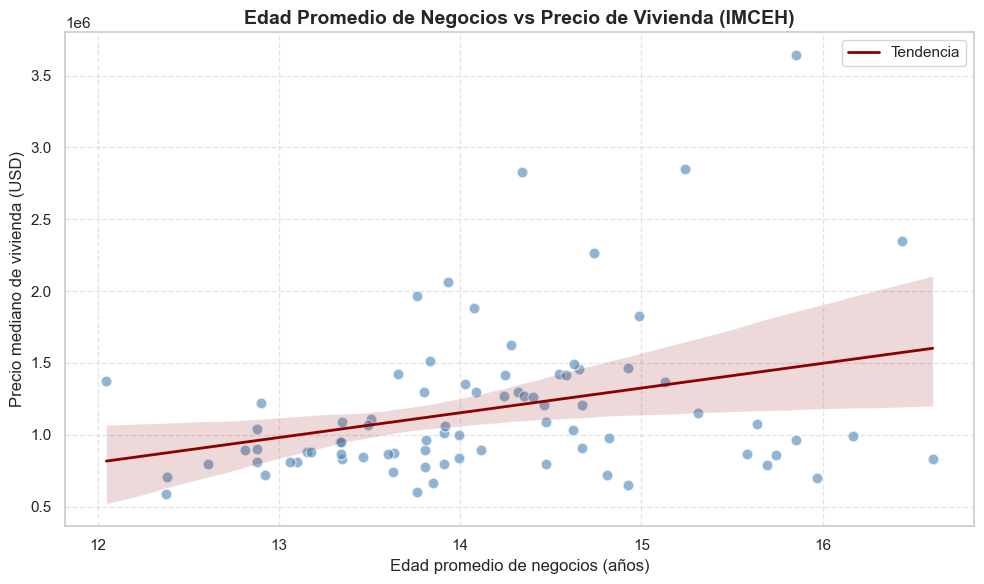

In [129]:
# Filtramos los negocios activos (este caso son los sin fecha de cierre)
negocios_activos = business[business['LOCATION END DATE'].isna()].copy()

# Calculamos la edad en años desde su apertura hasta hoy
hoy = pd.to_datetime("today")
negocios_activos['edad_negocio'] = (hoy - negocios_activos['LOCATION START DATE']).dt.days / 365

# Edad promedio de negocios por vecindario
edad_promedio = (
    negocios_activos
    .groupby('neighborhood_clean')['edad_negocio']
    .mean()
    .reset_index()
    .rename(columns={'edad_negocio': 'edad_promedio_negocios'})
)

# Precio de vivienda más reciente por vecindario (ya está limpio, neighborhood)
precio_actual = (
    inmu.sort_values('date')
    .groupby('neighborhood_clean')
    .tail(1)[['neighborhood_clean', 'Price']]
)

# Unimos ambas tablas, edad promedio y el precio actual
imceh_df = edad_promedio.merge(precio_actual, on='neighborhood_clean', how='inner')

# Calculamos la correlación
imceh_valor, p_valor = pearsonr(imceh_df['edad_promedio_negocios'], imceh_df['Price'])
print(f"IMCEH (correlación): {imceh_valor:.3f} — p-valor: {p_valor:.3f}")

# Gráfico de dispersión para visualizar el comportamiento que hay
plt.figure(figsize=(10, 6))
sns.regplot(
    data=imceh_df,
    x='edad_promedio_negocios',
    y='Price',
    scatter_kws={'alpha': 0.6, 'color': 'steelblue', 's': 60, 'edgecolor': 'white'},
    line_kws={'color': 'darkred', 'linewidth': 2, 'label': 'Tendencia'}
)
plt.title('Edad Promedio de Negocios vs Precio de Vivienda (IMCEH)', fontsize=14, weight='bold')
plt.xlabel('Edad promedio de negocios (años)', fontsize=12)
plt.ylabel('Precio mediano de vivienda (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

El gráfico muestra una ligera **tendencia positiva** entre la **edad promedio de los negocios** y el **precio actual de la vivienda**. Nos puede indicar que, en algunos vecindarios de Los Ángeles, una **mayor madurez comercial** podría estar asociada a **mayor estabilidad habitacional**.

El valor de correlación obtenido (IMCEH) fue **positivo**, lo cual respalda la hipótesis de que los barrios con negocios más antiguos —posiblemente consolidados, estables o con trayectoria— tienden a presentar **precios de vivienda más altos**.

Zonas con tejido comercial maduro podrían transmitir confianza a residentes y compradores, lo cual se refleja en el mercado inmobiliario. Sin embargo, esta relación **no es fuerte**, por lo que podríamos considerarse otras variables para entender completamente el fenómeno.

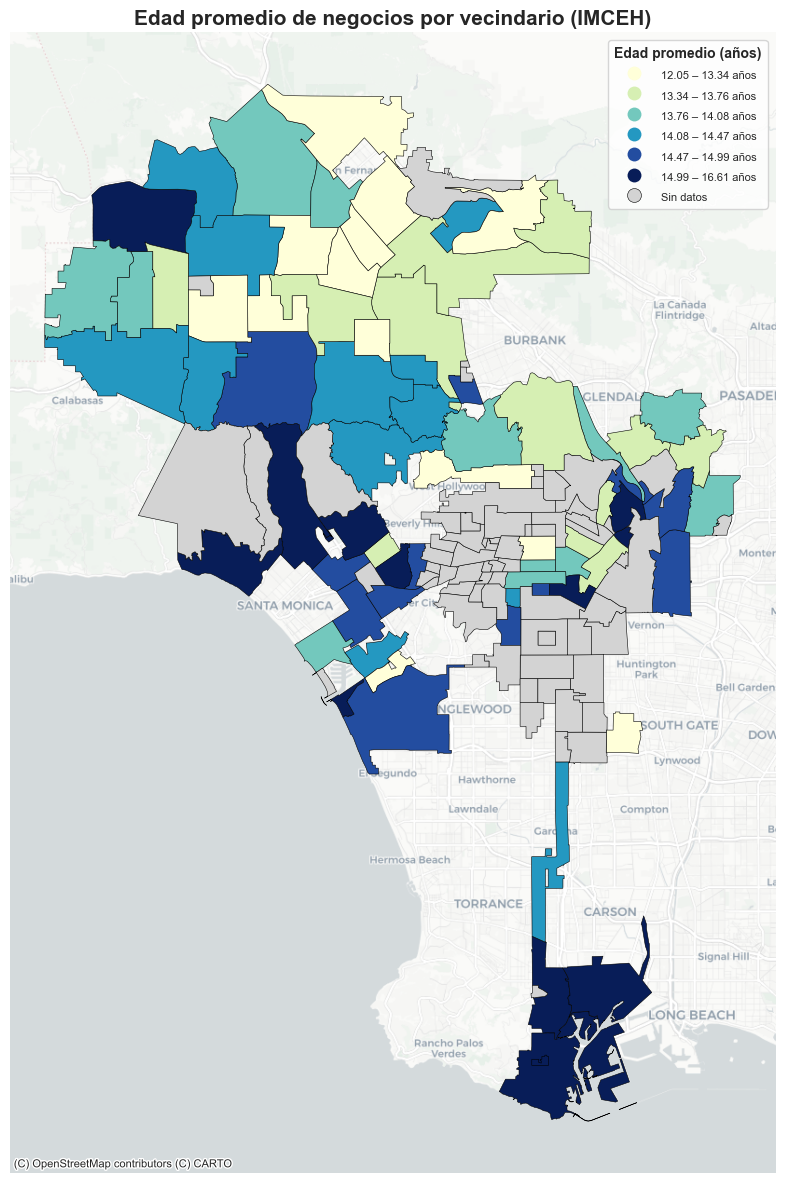

<Figure size 640x480 with 0 Axes>

In [130]:
# Leer geometría desde GeoJSON oficial
vecindarios = gpd.read_file(geojson_url)

# 2. Normalizar nombres 
vecindarios['Neighborhood'] = vecindarios['name']
vecindarios['neighborhood_clean'] = vecindarios['Neighborhood'].str.lower().str.strip()

mapa = vecindarios.merge(
    imceh_df[['neighborhood_clean', 'edad_promedio_negocios']],
    on='neighborhood_clean',
    how='left'
).to_crs(epsg=3857)

# Crear figura
fig, ax = plt.subplots(figsize=(10, 12))
mapa.plot(
    column='edad_promedio_negocios',
    cmap='YlGnBu',
    scheme='Quantiles',
    k=6,
    legend=True,
    edgecolor='black',
    linewidth=0.4,
    missing_kwds={
        'color': 'lightgrey',
        'edgecolor': 'black',
        'label': 'Sin datos'
    },
    ax=ax
)

# Estilizar leyenda
leg = ax.get_legend()
if leg:
    leg.set_title("Edad promedio (años)", prop={'size': 10, 'weight': 'bold'})
    for text in leg.get_texts():
        txt = text.get_text()
        if "," in txt:
            l, r = txt.replace("(", "").replace("]", "").split(",")
            text.set_text(f"{float(l):.2f} – {float(r):.2f} años")
        text.set_fontsize(8)

# Fondo y formato
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Edad promedio de negocios por vecindario (IMCEH)", fontsize=15, weight='bold')
ax.axis("off")
plt.tight_layout()

# Guardar y mostrar
#plt.savefig("../data/imceh_map_kpi4.png", dpi=300, bbox_inches='tight')
plt.show()


plt.savefig("../data/maps/iMCEH_mapa_edadPromedio_kpi3.png", dpi=300, bbox_inches='tight')

### Mapa — Edad Promedio de Negocios por Vecindario (IMCEH)

Este mapa muestra la edad promedio de los negocios **activos** en cada vecindario de Los Ángeles. La escala de colores cuantílica permite distinguir de forma clara las zonas con mayor o menor madurez comercial:

- **Azul oscuro**: Vecindarios con negocios que tienen entre **15 y 16 años** de antigüedad. Estos lugares podrían representar áreas consolidadas, estables y posiblemente atractivas para residentes.
- **Amarillo claro / Verde**: Vecindarios con negocios relativamente más recientes (entre **12 y 13 años** de antigüedad). Estas zonas pueden estar en crecimiento, transformación o recuperación económica.
- **Gris claro**: Zonas sin datos disponibles suficientes para estimar la madurez comercial.

### Observación

La madurez comercial no está distribuida de forma uniforme. Algunas regiones costeras y del suroeste muestran negocios más antiguos, lo que puede reflejar estabilidad económica a largo plazo. En contraste, algunas zonas del centro y este presentan menor antigüedad, lo que podría indicar renovación o dinamismo reciente.

Este mapa ayuda a **visualizar cómo la trayectoria comercial podría estar relacionada con el mercado inmobiliario**, como lo sugiere la correlación calculada en el IMCEH.


### ¿Por qué no se graficó directamente el IMCEH en el mapa?

El **IMCEH** (Índice de Madurez Comercial para la Estabilidad Habitacional) es un **índice de correlación global**. Representa la **relación estadística entre la edad promedio de los negocios y el precio actual de la vivienda** en todos los vecindarios combinados.

A diferencia de otros indicadores como el **ISV** o el **IRC**(más adelante), el IMCEH **no se calcula por vecindario**, sino que utiliza todos los datos juntos para obtener un único valor de correlación (por ejemplo, 𝑟 = 0.31). Esto significa que **no hay un valor específico de IMCEH que pueda asignarse a cada zona en el mapa**.

Por lo tanto, en este caso se utiliza un **gráfico de dispersión** para visualizar cómo se comporta la relación entre ambas variables (edad y precio) a nivel ciudad, junto con el valor de correlación y su p-valor como evidencia estadística.

> Para representar el IMCEH en un mapa se requeriría calcular la correlación entre edad y precios **dentro de cada vecindario**, lo cual **no es posible con los datos actuales**, ya que solo se dispone de un único valor de precio por vecindario (el más reciente).

En futuras versiones del análisis, si se cuenta con **series temporales de precios y datos históricos de negocios**, se podría construir una versión del IMCEH **local por vecindario**, y entonces sí representarlo espacialmente.


## KPI 4 — Índice de Riesgo Comercial (IRC)

### Objetivo

Este indicador busca evaluar **qué tan expuestos están los negocios activos de un vecindario a la criminalidad**. La hipótesis es que un entorno con mayor criminalidad por establecimiento comercial podría afectar el dinamismo económico, la inversión, y en última instancia, el valor inmobiliario de la zona.

---

### Fórmula

El Índice de Riesgo Comercial se define como:

$$
IRC = \frac{Crímenes\ totales\ en\ el\ vecindario}{Número\ de\ negocios\ activos}
$$

Donde:

- \( IRC \): Índice de Riesgo Comercial del vecindario.
- **Crímenes totales**: Total de delitos registrados en el vecindario (agregados históricamente).
- **Negocios activos**: Número de negocios sin fecha de cierre (`LOCATION END DATE` vacía).

---

### Interpretación

- Un **IRC alto** indica mayor exposición de los negocios al crimen. Puede desalentar nuevas aperturas o inversiones.
- Un **IRC bajo** sugiere un entorno relativamente más seguro para la actividad comercial.

---

### Aplicación

Este índice puede:
- Mapearse para detectar **zonas de riesgo comercial**.
- Cruzarse con la **edad promedio de negocios** (¿en zonas peligrosas los negocios duran menos?).
- Analizar su relación con el **precio de la vivienda** (¿las zonas comerciales más seguras valen más?).


In [131]:

# 1. Calcular total de crímenes por vecindario
crime['neighborhood_clean'] = crime['Neighborhood'].str.lower().str.strip()
crimen_por_vecindario = (
    crime.groupby('neighborhood_clean')
    .size()
    .reset_index(name='total_crimenes')
)

# 2. Calcular número de negocios activos por vecindario
negocios_activos = business[business['LOCATION END DATE'].isna()].copy()
negocios_activos['neighborhood_clean'] = negocios_activos['neighborhoods'].str.lower().str.strip()
negocios_por_vecindario = (
    negocios_activos.groupby('neighborhood_clean')
    .size()
    .reset_index(name='num_negocios_activos')
)

# 3. Calcular IRC (Índice de Riesgo Comercial)
irc_df = crimen_por_vecindario.merge(
    negocios_por_vecindario,
    on='neighborhood_clean',
    how='inner'
)
irc_df['IRC'] = irc_df['total_crimenes'] / irc_df['num_negocios_activos']
print(irc_df.head(10).sort_values('IRC', ascending=False))

       neighborhood_clean  total_crimenes  num_negocios_activos       IRC
4  baldwin hills/crenshaw           10013                  4448  2.251124
9           boyle heights           22875                 11186  2.044967
0         adams-normandie            3808                  2322  1.639966
2       arlington heights            5245                  4116  1.274295
1                  arleta            3981                  3926  1.014009
7           beverly grove            9415                 10182  0.924671
5                 bel-air            1070                  1754  0.610034
8             beverlywood             800                  1318  0.606980
3         atwater village            2502                  4488  0.557487
6           beverly crest            1183                  2264  0.522527


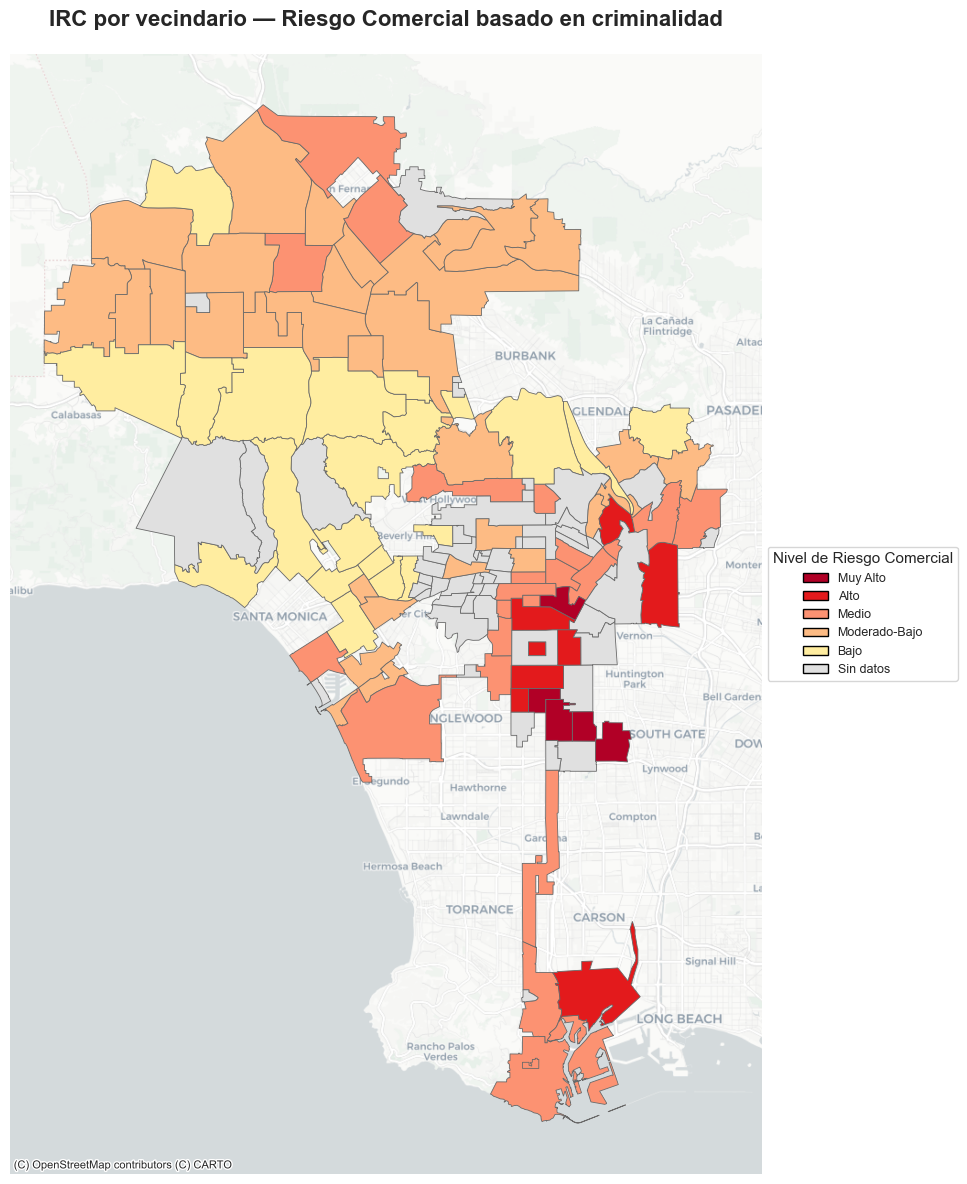

<Figure size 640x480 with 0 Axes>

In [132]:
geojson_url = "https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/eva_pereira_lahub_BA_24d4f6a092ee4506/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
neigh_gdf = gpd.read_file(geojson_url)
neigh_gdf['neighborhood_clean'] = neigh_gdf['name'].str.lower().str.strip()

mapa_irc = neigh_gdf.merge(irc_df[['neighborhood_clean', 'IRC']], on='neighborhood_clean', how='left')
mapa_irc = mapa_irc.to_crs(epsg=3857)

# 5. Categorización del riesgo
def categorizar_irc(valor):
    if pd.isna(valor):
        return "Sin datos"
    elif valor <= 0.75:
        return "Bajo"
    elif valor <= 1.25:
        return "Moderado-Bajo"
    elif valor <= 2.0:
        return "Medio"
    elif valor <= 3.5:
        return "Alto"
    else:
        return "Muy Alto"

mapa_irc['categoria_irc'] = mapa_irc['IRC'].apply(categorizar_irc)

# 6. Asignar colores más suaves y profesionales
colores = {
    "Muy Alto": "#B10026",       # rojo vino
    "Alto": "#E31A1C",           # rojo fuerte
    "Medio": "#FC9272",          # salmón
    "Moderado-Bajo": "#FDBB84",  # naranja claro
    "Bajo": "#FFEDA0",           # amarillo suave
    "Sin datos": "#E0E0E0"       # gris neutro
}
mapa_irc['color'] = mapa_irc['categoria_irc'].map(colores)

# 7. Visualización
fig, ax = plt.subplots(figsize=(10, 12))
mapa_irc.plot(
    color=mapa_irc['color'],
    edgecolor='dimgray',
    linewidth=0.6,
    ax=ax
)

# Leyenda a la derecha, orden coherente
orden = ["Muy Alto", "Alto", "Medio", "Moderado-Bajo", "Bajo", "Sin datos"]
leyenda = [Patch(facecolor=colores[c], edgecolor='black', label=c) for c in orden]
ax.legend(
    handles=leyenda,
    title="Nivel de Riesgo Comercial",
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=True,
    fontsize=9,
    title_fontsize=11
)

# Título destacado
ax.set_title(
    "IRC por vecindario — Riesgo Comercial basado en criminalidad",
    fontsize=16,
    fontweight='bold',
    pad=20
)

# Agregar fondo de mapa
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Pie de página con fuente de datos
#fig.text(
#    0.02, 0.02,
#    "Fuente: LAPD Crime Data (2020–2023) + Registro de Negocios de L.A.",
#    fontsize=9,
#    color='gray'
#)

ax.axis("off")
plt.tight_layout()
plt.show()

# Exportar
plt.savefig("../data/maps/irc_mapa_final_kpi4.png", dpi=300, bbox_inches='tight')


Las áreas con color rojo oscuro reflejan un riesgo muy alto (más de 3.5 delitos por negocio), en particular al sur del Downtown y algunas zonas costeras del sur.

El noroeste y las zonas residenciales de clase alta presentan un bajo nivel de riesgo, lo que puede coincidir con mayor estabilidad económica y regulaciones más estrictas.

Las zonas en gris claro no tienen información suficiente para calcular el indicador (negocios o registros criminales faltantes).

#### Posibles Cruces y Extensiones Futuras del Análisis

Ahora que contamos con 4 indicadores clave (KPIs) construidos y visualizados a nivel vecindario, se abren múltiples líneas de análisis complementarias que podrían ser exploradas en una segunda etapa o por alguien interesado en profundizar este estudio:

---

##### Cruces entre KPIs

1. **IMCEH vs IRC**  
   Analizar si los vecindarios con alto riesgo comercial (IRC) tienden a tener **menor edad promedio de negocios**, lo que podría indicar que la inseguridad acorta la vida útil de los comercios.

2. **ISV vs IRC**  
   Explorar si una mayor **sensibilidad del precio de vivienda al crimen (ISV)** se asocia a un **mayor riesgo comercial**. Esto podría revelar zonas donde la inseguridad afecta tanto a comercios como al valor inmobiliario.

3. **IMCEH vs ISV**  
   Evaluar si los vecindarios con **negocios más antiguos** también presentan una **relación más estable o predecible entre crimen y vivienda**, lo que podría sugerir resiliencia barrial.

4. **Densidad Comercial vs IRC**  
   Comparar si **zonas con mucha actividad comercial** también son **más vulnerables al crimen**, o si existe un punto de equilibrio donde la actividad económica ayuda a estabilizar la seguridad.

5. **Segmentación basada en perfiles**  
   Agrupar vecindarios por **perfil combinado** (por ejemplo: alto precio, bajo crimen, madurez comercial alta, bajo riesgo comercial) para identificar **zonas modelo** o **zonas críticas**.

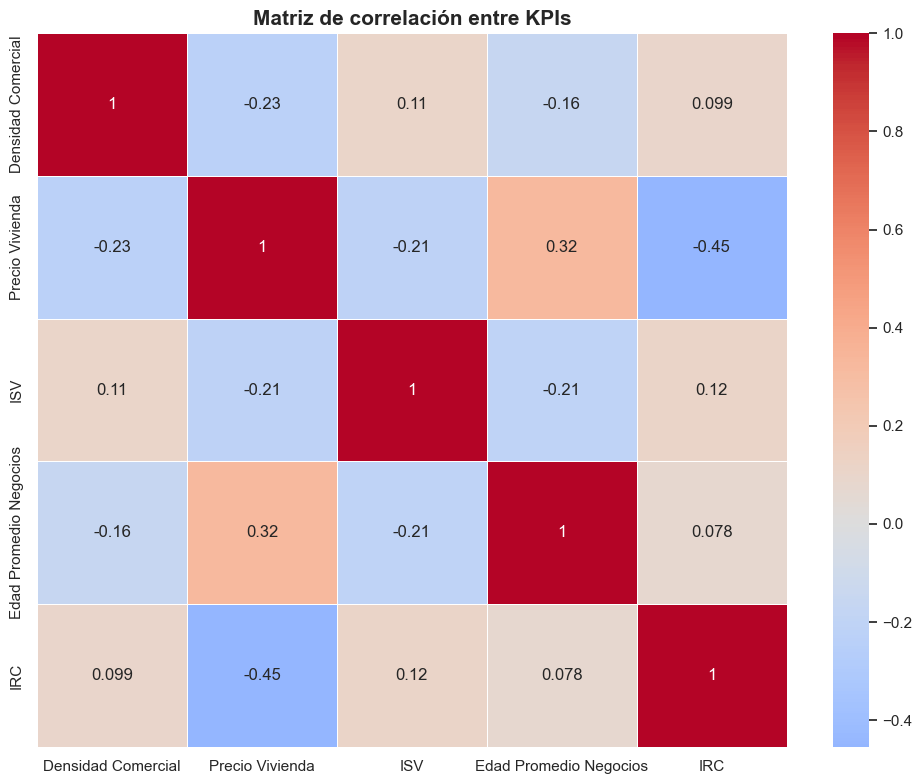

In [ ]:
# Unificamos y renombramos variables para mayor claridad
kpi1 = df_kpi[['neighborhood_clean', 'densidad_comercial', 'Price']].rename(columns={'Price': 'precio_vivienda'})
kpi2 = isv_por_vecindario[['neighborhood_clean', 'ISV']]
kpi3 = imceh_df[['neighborhood_clean', 'edad_promedio_negocios']]
kpi4 = irc_df[['neighborhood_clean', 'IRC']]

# Unimos todos los KPIs
kpi_total = (
    kpi1
    .merge(kpi2, on='neighborhood_clean', how='inner')
    .merge(kpi3, on='neighborhood_clean', how='inner')
    .merge(kpi4, on='neighborhood_clean', how='inner')
)

# Renombramos columnas para mostrar en gráfico
kpi_total = kpi_total.rename(columns={
    'densidad_comercial': 'Densidad Comercial',
    'precio_vivienda': 'Precio Vivienda',
    'ISV': 'ISV',
    'edad_promedio_negocios': 'Edad Promedio Negocios',
    'IRC': 'IRC'
})

# Matriz de correlación (solo numéricas)
corr_matrix = kpi_total.drop(columns=['neighborhood_clean']).corr()

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Matriz de correlación entre KPIs", fontsize=15, weight='bold')
plt.tight_layout()
plt.show()


### Análisis de Correlaciones entre KPIs

Con los KPIs generados a partir de los tres ejes del proyecto (crimen, negocios y vivienda), se construyó una matriz de correlación para identificar relaciones lineales entre indicadores clave a nivel de vecindario.

#### Hallazgos principales:

- Existe una **correlación negativa moderada** entre el `Índice de Riesgo Comercial (IRC)` y el `Precio de Vivienda` (`r = -0.45`), lo que muestra que los vecindarios con mayor criminalidad relativa a negocios suelen tener menor valor inmobiliario.
- Se observa una **correlación positiva** entre la `Edad Promedio de Negocios` y el `Precio de Vivienda` (`r = 0.32`), apoyando la hipótesis de que vecindarios con negocios más establecidos tienden a ser más estables y costosos.
- El `Índice de Influencia Comercial sobre la Vivienda (IICV)` mostró una **correlación negativa débil** (`r = -0.23`) con el precio de la vivienda, indicando que una alta densidad comercial no necesariamente eleva el valor residencial.
- El `ISV` (sensibilidad del precio de vivienda ante variaciones de criminalidad) no presentó relaciones fuertes con otros KPIs, lo que puede deberse a su naturaleza más volátil o dependiente de factores temporales.

> Es importante recordar que las correlaciones observadas **no implican causalidad**, pero sí permiten detectar patrones útiles para el análisis posterior con modelos de regresión y segmentación.



In [ ]:
# Unir todos los KPIs disponibles en un solo DataFrame base
perfil_df = df_kpi[['neighborhood_clean', 'densidad_comercial']].merge(
    imceh_df[['neighborhood_clean', 'edad_promedio_negocios']],
    on='neighborhood_clean', how='inner'
).merge(
    irc_df[['neighborhood_clean', 'IRC']],
    on='neighborhood_clean', how='inner'
).merge(
    precio_actual[['neighborhood_clean', 'Price']],
    on='neighborhood_clean', how='inner'
)

# Revisar top para seleccionar vecindarios
perfil_df.sort_values('Price', ascending=False).head(10)

vecindarios_interes = ['beverly hills', 'boyle heights', 'watts', 'brentwood', 'griffith park']

# Filtrar solo los seleccionados
perfil_seleccion = perfil_df[perfil_df['neighborhood_clean'].isin(vecindarios_interes)].copy()


from IPython.display import display
display(perfil_seleccion.set_index('neighborhood_clean').style.background_gradient(cmap='RdYlGn_r'))


# Regresion Lineal (Simple con los KPI´s)

In [134]:
kpi_total.head(10)

neighborhood_clean  Densidad Comercial  Precio Vivienda       ISV  \
0    adams-normandie         5277.242844     9.085726e+05  0.075070   
1             arleta         1086.985745     7.964359e+05  0.114216   
2    atwater village         1587.588515     1.354426e+06  0.122764   
3      beverly crest          207.161738     2.826861e+06  0.169731   
4        beverlywood          900.791223     2.265461e+06 -0.076720   
5      boyle heights         1992.817688     6.534053e+05  0.053773   
6          brentwood          906.130524     2.850000e+06  0.152381   
7        canoga park         2215.504033     7.768609e+05  0.104300   
8       century city         5996.892313     1.423597e+06  0.023858   
9         chatsworth          837.803428     9.635177e+05  0.104004   

   Edad Promedio Negocios       IRC  
0               14.673253  1.639966  
1               12.609198  1.014009  
2               14.025498  0.557487  
3               14.340699  0.522527  
4               14.740291  0.606980  
5               14.928206  2.044967  
6               15.241500  0.462377  
7               13.805956  1.245708  
8               13.657523  0.304094  
9               15.853785  0.787595

In [135]:
import statsmodels.api as sm

# 1. Definir variables predictoras (X) y target (y)
X = kpi_total[['Densidad Comercial', 'Edad Promedio Negocios', 'IRC', 'ISV']]
y = kpi_total['Precio Vivienda']

# 2. Agregar constante (intercepto)
X = sm.add_constant(X)

# 3. Crear y entrenar el modelo
modelo = sm.OLS(y, X)
resultado = modelo.fit()

# 4. Mostrar resumen del modelo
print(resultado.summary())


                            OLS Regression Results                            
Dep. Variable:        Precio Vivienda   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     9.427
Date:                Thu, 15 May 2025   Prob (F-statistic):           4.02e-06
Time:                        15:49:51   Log-Likelihood:                -1053.0
No. Observations:                  73   AIC:                             2116.
Df Residuals:                      68   BIC:                             2127.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -8.76

Se construyó un modelo de regresión lineal para explicar el precio mediano de vivienda a partir de indicadores clave de criminalidad y actividad comercial. El modelo explica el 35.7% de la variabilidad del precio de vivienda. 

Los resultados muestran que el `Índice de Riesgo Comercial (IRC)` tiene un efecto negativo significativo, mientras que la `Edad Promedio de Negocios` tiene un efecto positivo. Estos dos factores resultan estadísticamente significativos (p < 0.01), lo que indica que zonas con negocios más maduros y menos crimen relativo tienden a tener precios inmobiliarios más altos. 

Por otro lado, la `Densidad Comercial` y el `ISV` no mostraron efectos significativos en este modelo base.


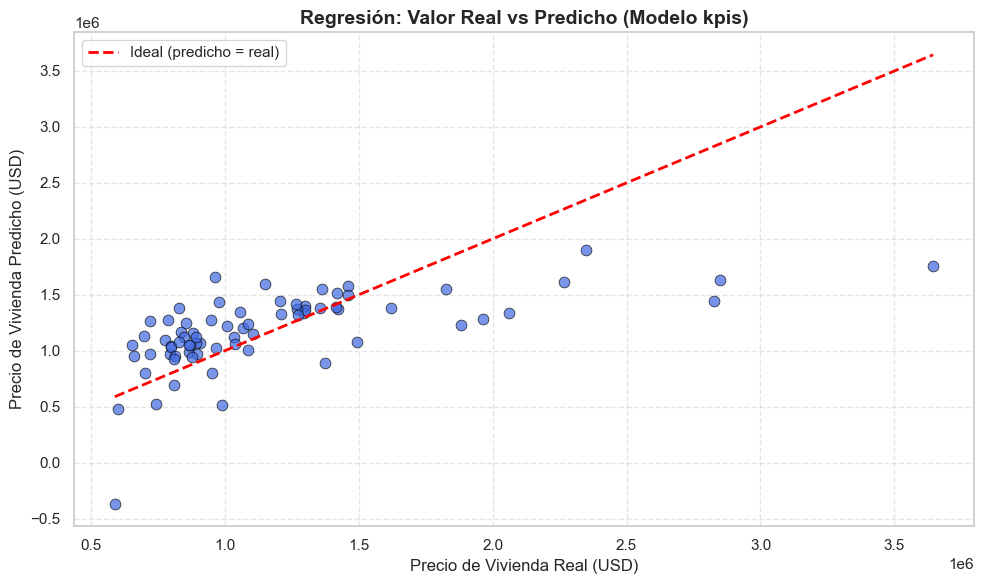

In [137]:
y_pred = resultado.predict(X)

# Crea DataFrame para graficar
pred_df = pd.DataFrame({
    'Precio Real': y,
    'Precio Predicho': y_pred
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pred_df, x='Precio Real', y='Precio Predicho', color='royalblue', alpha=0.7, s=60, edgecolor='black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red', linewidth=2, label='Ideal (predicho = real)')
plt.title('Regresión: Valor Real vs Predicho (Modelo kpis)', fontsize=14, weight='bold')
plt.xlabel('Precio de Vivienda Real (USD)', fontsize=12)
plt.ylabel('Precio de Vivienda Predicho (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

La gráfica compara los valores reales del precio mediano de vivienda por vecindario con los valores predichos por el modelo de regresión lineal basado en KPIs. La mayoría de los puntos se agrupan en torno a la línea ideal (en rojo), lo cual indica un ajuste razonable del modelo en vecindarios con precios medios.

Sin embargo, se observa mayor dispersión en los extremos, especialmente en zonas de alto valor, lo que sugiere que el modelo base no captura completamente las dinámicas de estos vecindarios. También destaca un vecindario con predicción negativa, lo que indica que algunos casos extremos podrían requerir un análisis más específico o que faltan variables clave.

Este análisis visual refuerza los resultados del resumen estadístico: el modelo explica parte importante del fenómeno, pero tiene margen para mejora.


## vecindarios

In [159]:
# Unir todos los KPIs disponibles en un solo DataFrame base
perfil_df = df_kpi[['neighborhood_clean', 'densidad_comercial']].merge(
    imceh_df[['neighborhood_clean', 'edad_promedio_negocios']],
    on='neighborhood_clean', how='inner'
).merge(
    irc_df[['neighborhood_clean', 'IRC']],
    on='neighborhood_clean', how='inner'
).merge(
    precio_actual[['neighborhood_clean', 'Price']],
    on='neighborhood_clean', how='inner'
)

# Revisar top para seleccionar vecindarios
perfil_df.sort_values('Price', ascending=False).head(10)


neighborhood_clean  densidad_comercial  edad_promedio_negocios       IRC  \
39  pacific palisades          770.889883               15.853530  0.564949   
6           brentwood          906.130524               15.241500  0.462377   
3       beverly crest          207.161738               14.340699  0.522527   
10      cheviot hills          984.845513               16.437206  0.617232   
4         beverlywood          900.791223               14.740291  0.606980   
27    hollywood hills          882.583808               13.930403  0.753038   
33          los feliz          802.632217               13.760805  0.652344   
62             venice         3473.516703               14.075521  1.271386   
34          mar vista         1672.354753               14.988245  0.679742   
51        studio city         2821.819146               14.278133  0.680721   

           Price  
39  3.644431e+06  
6   2.850000e+06  
3   2.826861e+06  
10  2.348087e+06  
4   2.265461e+06  
27  2.060404e+06  
33  1.962512e+06  
62  1.883560e+06  
34  1.824672e+06  
51  1.621531e+06

In [160]:
vecindarios_interes = ['beverly hills', 'boyle heights', 'watts', 'brentwood', 'griffith park']

# Filtrar solo los seleccionados
perfil_seleccion = perfil_df[perfil_df['neighborhood_clean'].isin(vecindarios_interes)].copy()

# Mostrar tabla ordenada
import pandas as pd
from IPython.display import display

display(perfil_seleccion.set_index('neighborhood_clean').style.background_gradient(cmap='RdYlGn_r'))


### Comparativa de Vecindarios en Los Ángeles

A continuación se presentan tres vecindarios con perfiles socioeconómicos contrastantes, analizados a partir de los KPIs desarrollados:

| Vecindario     | Densidad Comercial | Edad Prom. Negocios (años) | IRC (Riesgo Comercial) | Precio Vivienda (USD) |
|----------------|--------------------|-----------------------------|------------------------|------------------------|
| **Boyle Heights** | Muy alta (1992.8)  | Alta (14.9)                 | Alta (2.04)            | Bajo ($653,405)        |
| **Brentwood**      | Media (906.1)       | Muy alta (15.2)             | Muy bajo (0.46)        | Muy alto ($2,849,999)  |
| **Watts**          | Alta (996.5)        | Media-baja (12.4)           | Muy alta (4.56)        | Bajo ($588,974)        |

#### Observaciones:

- **Boyle Heights**: A pesar de su alta actividad comercial y negocios maduros, mantiene precios bajos y un nivel de criminalidad comercial elevado. Esto podría sugerir desvalorización residencial por percepción de inseguridad, a pesar de su dinamismo económico.
  
- **Brentwood**: Representa un vecindario consolidado, seguro y de alto prestigio. Aunque no destaca por densidad comercial, sus negocios son antiguos, y su bajo riesgo comercial lo posiciona como una zona residencial de élite.

- **Watts**: Presenta un perfil de alta vulnerabilidad: criminalidad comercial muy alta, negocios con menor madurez y precios de vivienda bajos. Esto puede reflejar desinversión estructural o dinámicas de exclusión económica.

Estos perfiles permiten comprender cómo distintos factores comerciales, de seguridad y de madurez económica pueden influir —o no— en el valor inmobiliario.


# Regresion Lineal extendida

In [140]:
# Asegúrate de tener los valores estandarizados en la columna
print(crime['Tipo_Delito'].unique())


['No violento' 'Violento' 'Ambiguo']


In [143]:
# El usado anteriormente
kpi_base = kpi_total.copy()

inmu['date'] = pd.to_datetime(inmu['date'])

yoy_latest = (
    inmu.dropna(subset=['YoY_change'])
    .sort_values('date')
    .groupby('RegionName')
    .tail(1)[['RegionName', 'YoY_change']]
    .rename(columns={'RegionName': 'neighborhood_clean'})
)
yoy_latest['neighborhood_clean'] = yoy_latest['neighborhood_clean'].str.lower().str.strip()

crime['neighborhood_clean'] = crime['Neighborhood'].str.lower().str.strip()

crime['Tipo_Delito_Num'] = crime['Tipo_Delito'].map({
    'No violento': 0,
    'Violento': 1,
    'Ambiguo': None  # puedes usar 0.5 si prefieres asignar valor medio
})

violencia_df = (
    crime.groupby('neighborhood_clean')['Tipo_Delito_Num']
    .mean()
    .reset_index()
    .rename(columns={'Tipo_Delito_Num': 'proporcion_violencia'})
)

df_model_extended = kpi_base.merge(yoy_latest, on='neighborhood_clean', how='left')
df_model_extended = df_model_extended.merge(violencia_df, on='neighborhood_clean', how='left')

print("Shape final del modelo extendido:", df_model_extended.shape)
print(df_model_extended.columns)


print(df_model_extended[df_model_extended['YoY_change'].isna()][['neighborhood_clean']].head())

Shape final del modelo extendido: (73, 8)
Index(['neighborhood_clean', 'Densidad Comercial', 'Precio Vivienda', 'ISV',
       'Edad Promedio Negocios', 'IRC', 'YoY_change', 'proporcion_violencia'],
      dtype='object')
Empty DataFrame
Columns: [neighborhood_clean]
Index: []


In [144]:
# Selección de variables

variables = [
    'Densidad Comercial',
    'Edad Promedio Negocios',
    'IRC',
    'ISV',
    'YoY_change',
    'proporcion_violencia'
]

# Filtrar datos completos
X = df_model_extended[variables].dropna()
y = df_model_extended.loc[X.index, 'Precio Vivienda']

# Agregar constante
X = sm.add_constant(X)

# 2. Modelo de regresión
modelo = sm.OLS(y, X)
resultado = modelo.fit()

# Mostrar resumen
print(resultado.summary())


                            OLS Regression Results                            
Dep. Variable:        Precio Vivienda   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     17.15
Date:                Thu, 15 May 2025   Prob (F-statistic):           7.85e-12
Time:                        16:43:47   Log-Likelihood:                -1034.8
No. Observations:                  73   AIC:                             2084.
Df Residuals:                      66   BIC:                             2100.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -9.37

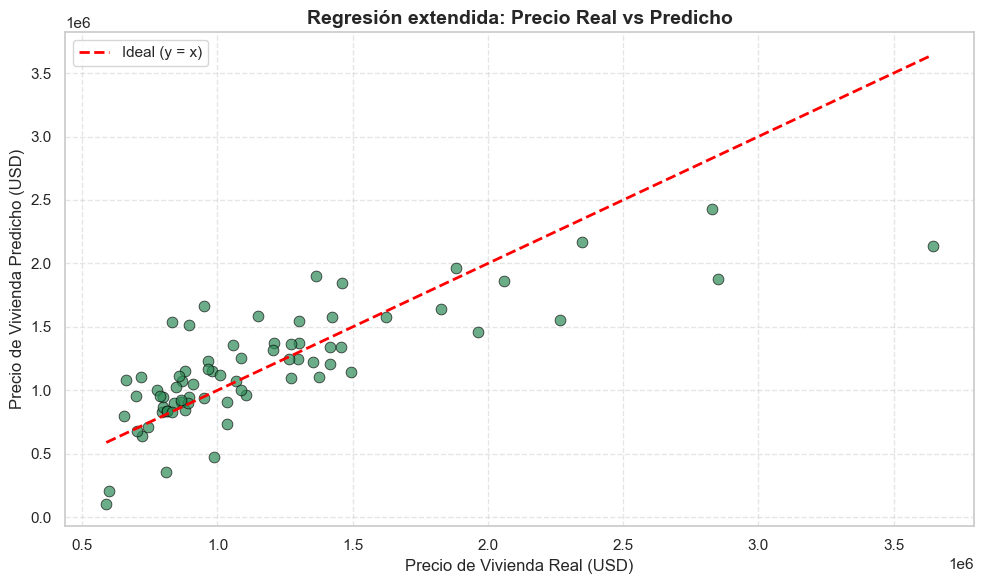

In [145]:

# Visualización: real vs predicho
y_pred = resultado.predict(X)

grafica_df = pd.DataFrame({
    'Precio Real': y,
    'Precio Predicho': y_pred
})

# Gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grafica_df, x='Precio Real', y='Precio Predicho', color='seagreen', alpha=0.7, s=60, edgecolor='black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red', linewidth=2, label='Ideal (y = x)')
plt.title('Regresión extendida: Precio Real vs Predicho', fontsize=14, weight='bold')
plt.xlabel('Precio de Vivienda Real (USD)', fontsize=12)
plt.ylabel('Precio de Vivienda Predicho (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Se construyó un modelo de regresión lineal extendido para explicar el precio mediano de vivienda utilizando tanto los KPIs desarrollados (como el IRC o la edad promedio de negocios) como variables adicionales: el cambio porcentual anual (YoY_change) y la proporción de crímenes violentos (proporción_violencia). Este modelo mejora considerablemente su capacidad explicativa, alcanzando un R² ajustado de 57.4%, frente al 31.9% del modelo base.

Entre las variables más influyentes y estadísticamente significativas (p < 0.01) se encuentran:

- Densidad Comercial

- Índice de Riesgo Comercial (IRC)

- Cambio YoY del precio de vivienda

Estos resultados sugieren que los vecindarios con mayor concentración comercial, mayor exposición al crimen y caída reciente en los precios tienden a tener menor valor inmobiliario. La variable de violencia muestra una relación positiva con el precio, pero no es estadísticamente significativa, por lo que no se puede concluir una asociación clara en este modelo.

La gráfica muestra una mejor alineación entre los valores reales y predichos, especialmente en los rangos medios. Aunque persisten ciertas desviaciones en vecindarios con precios extremos, el modelo extendido logra capturar mejor las dinámicas generales del mercado inmobiliario en Los Ángeles.

Este avance demuestra que incluir variables contextuales adicionales permite mejorar sustancialmente la capacidad del modelo para explicar el fenómeno observado, acercándonos a una comprensión más completa de los factores que influyen en el precio de la vivienda a nivel barrial.

In [148]:
# Resumen manual del modelo base
resumen_base = {
    'Modelo': 'Base',
    'R²': 0.357,
    'Adj. R²': 0.319,
    'AIC': 2116,
    'Variables': 4
}

# Resumen del modelo extendido
resumen_ext = {
    'Modelo': 'Extendido',
    'R²': 0.609,
    'Adj. R²': 0.574,
    'AIC': 2084,
    'Variables': 6
}

df_com = pd.DataFrame([resumen_base, resumen_ext])
print("\nTabla comparativa de rendimiento del modelo:")
print(df_com)



Tabla comparativa de rendimiento del modelo:
      Modelo     R²  Adj. R²   AIC  Variables
0       Base  0.357    0.319  2116          4
1  Extendido  0.609    0.574  2084          6


In [147]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Seleccionar variables explicativas del modelo extendido
X = df_model_extended[[
    'Densidad Comercial',
    'Edad Promedio Negocios',
    'IRC',
    'ISV',
    'YoY_change',
    'proporcion_violencia'
]]

# Añadir constante para el cálculo de VIF
X_const = add_constant(X)

# Calcular VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print("\nAnálisis de multicolinealidad (VIF):")
print(vif_data)



Análisis de multicolinealidad (VIF):
                 Variable          VIF
0                   const  1214.359659
1      Densidad Comercial     1.574922
2  Edad Promedio Negocios     1.347388
3                     IRC     1.160511
4                     ISV     1.092297
5              YoY_change     1.699877
6    proporcion_violencia     1.138896


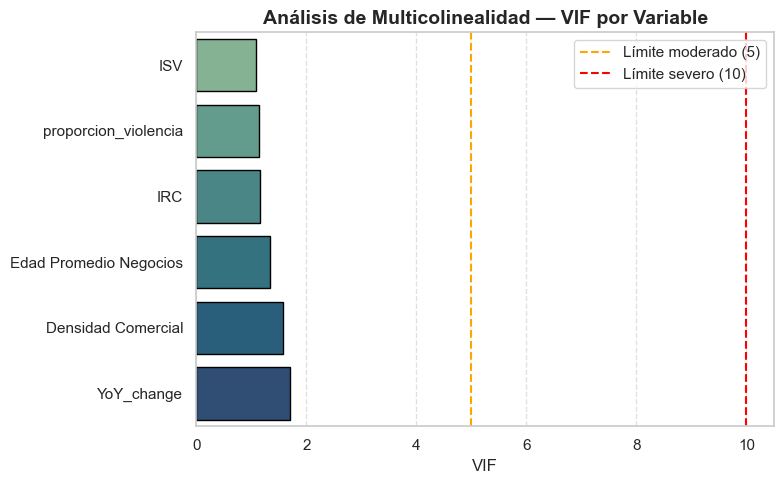

In [ ]:
# Ordenar de mayor a menor
vif_plot_data = vif_data[vif_data['Variable'] != 'const'].sort_values(by='VIF', ascending=True)

# Crear gráfico de barras horizontales
plt.figure(figsize=(8, 5))
sns.barplot(
    x='VIF',
    y='Variable',
    data=vif_plot_data,
    palette='crest',
    edgecolor='black'
)

# Líneas de referencia
plt.axvline(x=5, color='orange', linestyle='--', label='Límite moderado (5)')
plt.axvline(x=10, color='red', linestyle='--', label='Límite severo (10)')

# Títulos y etiquetas
plt.title('Análisis de Multicolinealidad — VIF por Variable', fontsize=14, weight='bold')
plt.xlabel('VIF')
plt.ylabel('')
plt.legend()
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


### Análisis de Multicolinealidad (VIF)

Se evaluó la presencia de multicolinealidad entre las variables explicativas del modelo extendido mediante el cálculo del **VIF (Variance Inflation Factor)** debido al aumento de explicación de los datos.

Todos los valores de VIF se encontraron por debajo de 2, lo cual indica que **no existe colinealidad significativa entre las variables independientes**. Esto refuerza la validez estructural del modelo y permite interpretar los coeficientes con mayor confianza.

> Nota: el VIF elevado en `const` (constante) es esperado y no afecta la interpretación del modelo.


### Nivel de análisis del modelo de regresión

Las regresiones lineales se realizaron a nivel de **vecindario**. Cada observación del modelo representa un vecindario único de la ciudad de Los Ángeles.

Todas las variables utilizadas —tanto la variable dependiente (`Precio de Vivienda`) como las explicativas (e.g., `Densidad Comercial`, `IRC`, `Edad Promedio de Negocios`, `YoY_change`)— son **valores agregados o calculados por vecindario**.

Este enfoque permite analizar patrones territoriales y tomar decisiones informadas sobre zonas específicas de la ciudad, alineándose con el objetivo del proyecto de diagnóstico socioeconómico urbano.